# Image Classification

In [1]:
from matplotlib import pyplot as plt
import os
import random

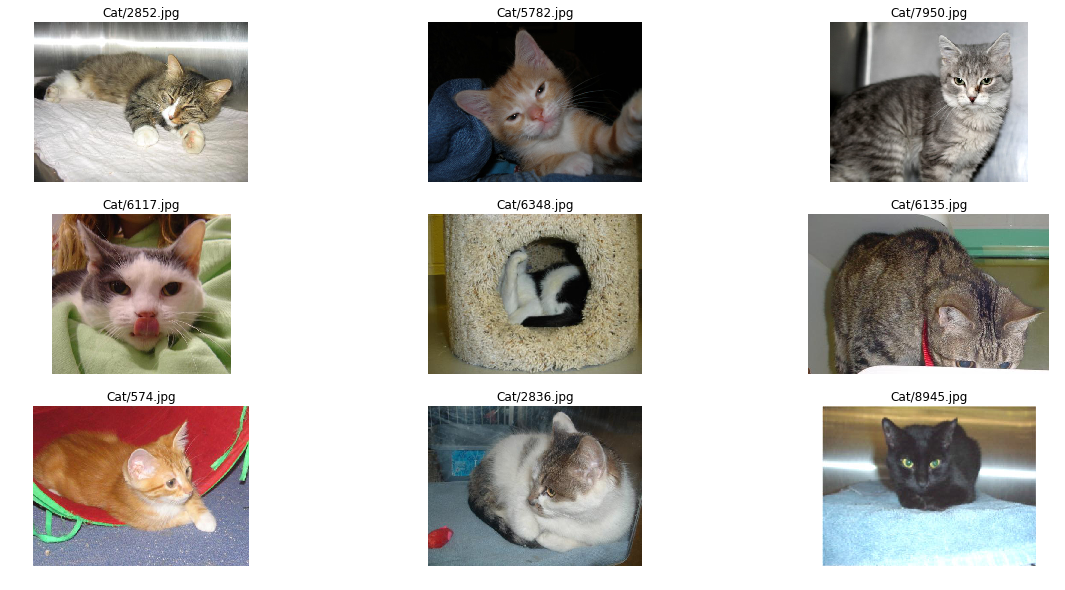

In [2]:
#get list of file names
_, _, cat_images = next(os.walk('F:\Datasets\PetImages\Cat'))

#prepare a 3x3 plot
fig, ax = plt.subplots(3,3, figsize=(20,10))

#randomly select and plot an image
for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('F:/Datasets/PetImages/Cat/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/'+img)
plt.show()

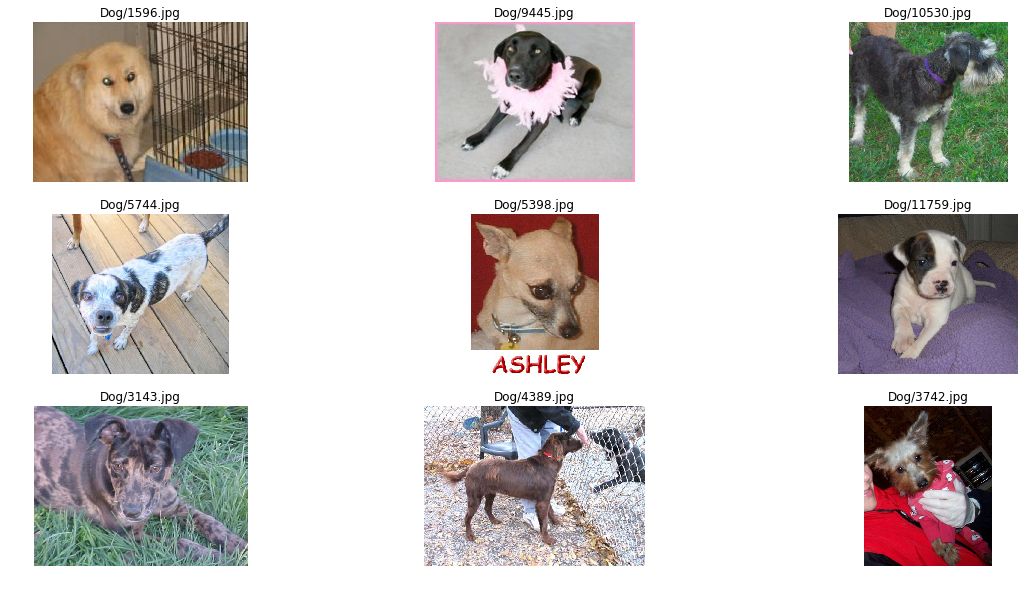

In [3]:
#get list of file names
_, _, dog_images = next(os.walk('F:\Datasets\PetImages\Dog'))

#prepare a 3x3 plot
fig, ax = plt.subplots(3,3, figsize=(20,10))

#randomly select and plot an image
for idx, img in enumerate(random.sample(dog_images, 9)):
    img_read = plt.imread('F:/Datasets/PetImages/Dog/'+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/'+img)
plt.show()

Using Keras, we can utilize the flow from directory method. This helps with preserving memory. In order to utilize it we need to organize our data locally into train and test subsets. 

Example:
- data -> train -> cat -> img
- data -> test -> dog -> img

The below functions will allow us to do that.

In [4]:
def train_test_split(src_folder, train_size = 0.8):
    #remove any existing folders and start from a clean slate
    shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
    shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
    shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

    #create new empty train and test folders
    os.makedirs(src_folder+'Train/Cat/')
    os.makedirs(src_folder+'Train/Dog/')
    os.makedirs(src_folder+'Test/Cat/')
    os.makedirs(src_folder+'Test/Dog/')

    #get the number of cats and dogs images
    _, _, cat_images = next(os.walk(src_folder+'Cat/'))
    files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
    for file in files_to_be_removed:
        cat_images.remove(file)
    num_cat_images = len(cat_images)
    num_cat_images_train = int(train_size * num_cat_images)
    num_cat_images_test = num_cat_images - num_cat_images_train

    _, _, dog_images = next(os.walk(src_folder+'Dog/'))
    files_to_be_removed = ['Thumbs.db', '11702.jpg']
    for file in files_to_be_removed:
        dog_images.remove(file)
    num_dog_images = len(dog_images)
    num_dog_images_train = int(train_size * num_dog_images)
    num_dog_images_test = num_dog_images - num_dog_images_train

    #randomly assign images to train and test
    cat_train_images = random.sample(cat_images, num_cat_images_train)
    for img in cat_train_images:
        shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
    cat_test_images  = [img for img in cat_images if img not in cat_train_images]
    for img in cat_test_images:
        shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

    dog_train_images = random.sample(dog_images, num_dog_images_train)
    for img in dog_train_images:
        shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
    dog_test_images  = [img for img in dog_images if img not in dog_train_images]
    for img in dog_test_images:
        shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

    # remove corrupted exif data from the dataset
    remove_exif_data(src_folder+'Train/')
    remove_exif_data(src_folder+'Test/')

In [5]:
def remove_exif_data(src_folder):
    _, _, cat_images = next(os.walk(src_folder+'Cat/'))
    for img in cat_images:
        try:
            piexif.remove(src_folder+'Cat/'+img)
        except:
            pass

    _, _, dog_images = next(os.walk(src_folder+'Dog/'))
    for img in dog_images:
        try:
            piexif.remove(src_folder+'Dog/'+img)
        except:
            pass

In [6]:
import shutil, sys

src_folder = 'F:/Datasets/PetImages/'
train_test_split(src_folder)

## Image Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range = 30,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

Using TensorFlow backend.


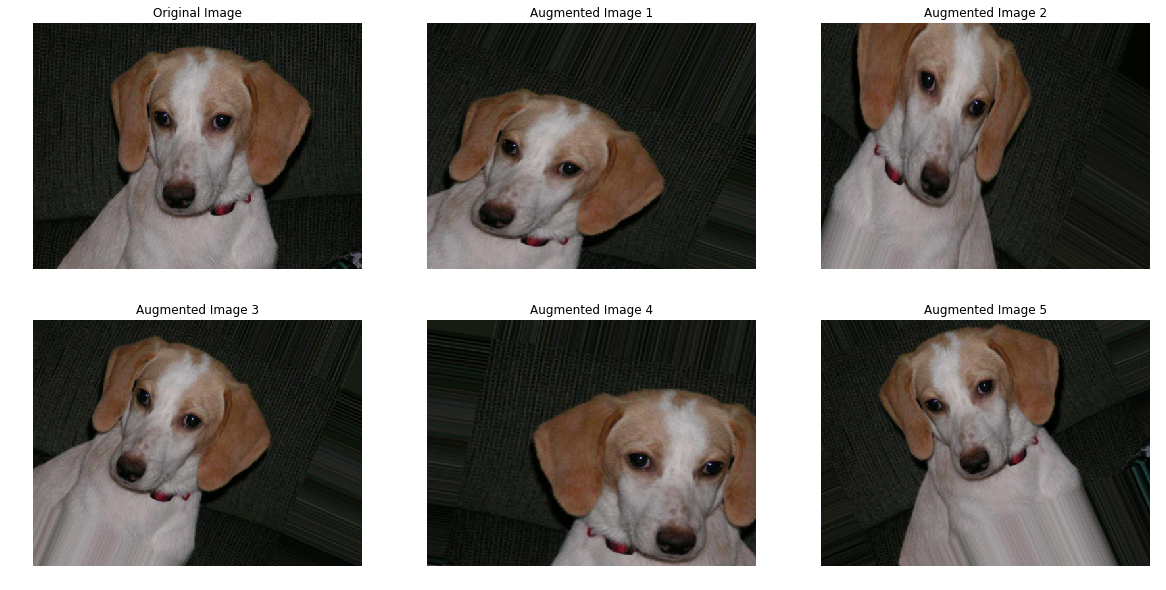

In [8]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk('F:/Datasets/PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread('F:/Datasets/PetImages/Train/Dog/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))
        
for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else:
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))
        
plt.show()

Augmenting images as above will help build the robustness of the model. 

## Build the CNN Model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [10]:
model = Sequential()

In [11]:
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 10

In [12]:
#add the first convolutional layer with 32 filters, each 3x3
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),
                input_shape = (INPUT_SIZE, INPUT_SIZE, 3),
                activation='relu'))

#add a max pooling layer
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))

#add another convolutional layer with 32 filters, each 3x3
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE),
                input_shape = (INPUT_SIZE, INPUT_SIZE, 3),
                activation='relu'))

#add a max pooling layer
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))

The convolution and pooling layers are done, now we need to flatten its input. 

In [13]:
model.add(Flatten())

Now, we can add fully connected layers.

In [14]:
model.add(Dense(units = 128, activation = 'relu'))

Before adding the last fully connected layer, it's good habit to add a dropout layer. This will help reduce overfitting.

In [15]:
#set 50% of the weights to 0
model.add(Dropout(0.5))

In [16]:
#add the last fully connected layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [17]:
#compile the model using the adam optimizer
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Use binary cross entropy for binary classification problems, and categorical cross entropy for multiclass classification problems. 

In [18]:
#train the CNN
training_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator. \
                flow_from_directory('F:/Datasets/PetImages/Train/', 
                                   target_size=(INPUT_SIZE, INPUT_SIZE),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary')

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH,
                   epochs=EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.

Epoch 1/10
 169/1250 [===>..........................] - ETA: 55s - loss: 0.6899 - accuracy: 0.5374

C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corr

 224/1250 [====>.........................] - ETA: 50s - loss: 0.6877 - accuracy: 0.5416

C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt

 351/1250 [=======>......................] - ETA: 43s - loss: 0.6804 - accuracy: 0.5623

C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corr

1031/1250 [=======================>......] - ETA: 10s - loss: 0.6406 - accuracy: 0.6210

C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting 

1250/1250 [==============================] - 57s 46ms/step - loss: 0.6303 - accuracy: 0.6325
Epoch 2/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.5391 - accuracy: 0.7273
Epoch 3/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.4905 - accuracy: 0.7622
Epoch 4/10
1250/1250 [==============================] - 58s 47ms/step - loss: 0.4591 - accuracy: 0.7839
Epoch 5/10
1250/1250 [==============================] - 58s 47ms/step - loss: 0.4333 - accuracy: 0.7973
Epoch 6/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.4088 - accuracy: 0.8104
Epoch 7/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.3833 - accuracy: 0.8262
Epoch 8/10
1250/1250 [==============================] - 59s 47ms/step - loss: 0.3611 - accuracy: 0.8386
Epoch 9/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.3393 - accuracy: 0.8513
Epoch 10/10
1250/1250 [==============================] - 54s 44ms/step - lo

In [19]:
#train the CNN
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator. \
                flow_from_directory('F:/Datasets/PetImages/Test/', 
                                   target_size=(INPUT_SIZE, INPUT_SIZE),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary')
score = model.evaluate_generator(test_set, steps=len(test_set))
for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

Found 5000 images belonging to 2 classes.


C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\kylem\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warning

loss: 0.43419137597084045
accuracy: 0.7936000227928162


In [20]:
from keras.applications.vgg16 import VGG16

INPUT_SIZE = 128
vgg16 = VGG16(include_top=False, weights='imagenet',
             input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

In [21]:
#freeze the rest of the layers
for layer in vgg16.layers:
    layer.trainable = False

In [22]:
#add a fully connected layer to the end of the neural network
from keras.models import Model

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

C:\Users\kylem\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17798408155513346655
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4941427507
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6443473729153740583
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [24]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [25]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale =  1./255)

training_set = training_data_generator. \
                flow_from_directory('F:/Datasets/PetImages/Train/',
                                   target_size = (INPUT_SIZE, INPUT_SIZE),
                                   batch_size = BATCH_SIZE,
                                   class_mode = 'binary')

test_set = testing_data_generator. \
            flow_from_directory('F:/Datasets/PetImages/Test/',
                               target_size = (INPUT_SIZE, INPUT_SIZE),
                               batch_size = BATCH_SIZE,
                               class_mode = 'binary')

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 10s 52ms/step - loss: 0.3964 - accuracy: 0.8053
Epoch 2/3
200/200 [==============================] - 10s 50ms/step - loss: 0.2929 - accuracy: 0.86690s - loss:
Epoch 3/3
200/200 [==============================] - 10s 49ms/step - loss: 0.2702 - accuracy: 0.8825


In [26]:
score = model.evaluate_generator(test_set, len(test_set))

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

loss: 0.48585188388824463
accuracy: 0.8777999877929688


Using transfer learning, we have improved the accuracy of our classifier over 8 points. Not bad...

In [57]:
test_set = testing_data_generator. \
            flow_from_directory('F:/Datasets/PetImages/Test/',
                               target_size = (INPUT_SIZE, INPUT_SIZE),
                               batch_size = BATCH_SIZE,
                               class_mode = 'binary')

strongly_wrong_idx = []
strongly_right_idx = []
weakly_wrong_idx = []

for i in range(test_set.__len__()):
    img = test_set.__getitem__(i)[0]
    pred_prob = model.predict(img)[0][0]
    pred_label = int(pred_prob>0.5)
    actual_label = int(test_set.__getitem__(i)[1][0])
    if pred_label != actual_label and (pred_prob > 0.8 or pred_prob < 0.2): strongly_wrong_idx.append(i)
    elif pred_label != actual_label and (pred_prob > 0.4 and pred_prob < 0.6): weakly_wrong_idx.append(i)
    elif pred_label == actual_label and (pred_prob > 0.8 or pred_prob < 0.2): strongly_right_idx.append(i)
    if (len(strongly_wrong_idx) >= 9 and len(strongly_right_idx) >= 9 and len(weakly_wrong_idx) >= 9): break

Found 5000 images belonging to 2 classes.


In [73]:
weakly_wrong_idx

[71, 78, 85, 156, 161, 215, 290]

In [74]:
test_set

In [75]:
from matplotlib import pyplot as plt
import random

INPUT_SIZE = 128

def plot_on_grid(test_set, idx_to_plot, img_size=INPUT_SIZE):
    fig, ax = plt.subplots(3,3, figsize=(20,10))
    for i, idx in enumerate(random.sample(idx_to_plot, 9)):
        img = test_set.__getitem__(idx)[0].reshape(img_size, img_size, 3)
        ax[int(i/3), i%3].imshow(img)
        ax[int(i/3), i%3].axis('off')

ValueError: cannot reshape array of size 786432 into shape (128,128,3)

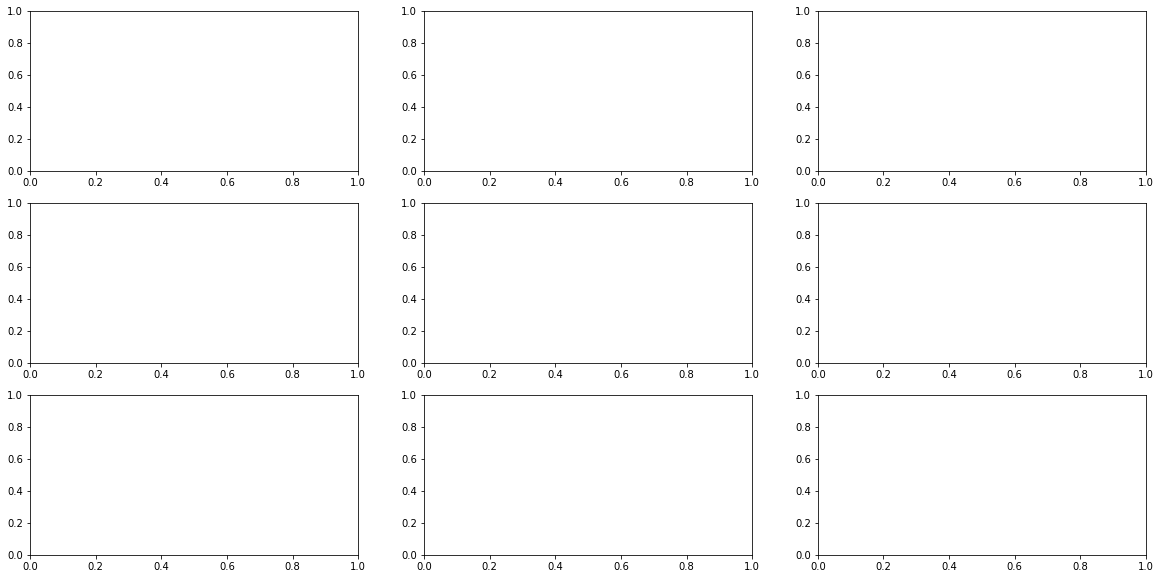

In [81]:
plot_on_grid(test_set, strongly_right_idx)